In [55]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/media/beans/ssd/bespoke')
sys.path.append(f'/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from train_utils import *
from input_prep import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Seq from real

In [56]:
sorted(glob.glob("/media/beans/ssd/bespoke_logging/*"))
#sorted(glob.glob("/home/beans/bespoke_logging/*"))

['/media/beans/ssd/bespoke_logging/run_351',
 '/media/beans/ssd/bespoke_logging/run_352',
 '/media/beans/ssd/bespoke_logging/run_353',
 '/media/beans/ssd/bespoke_logging/run_354',
 '/media/beans/ssd/bespoke_logging/run_355',
 '/media/beans/ssd/bespoke_logging/run_356',
 '/media/beans/ssd/bespoke_logging/run_357',
 '/media/beans/ssd/bespoke_logging/run_358',
 '/media/beans/ssd/bespoke_logging/run_359',
 '/media/beans/ssd/bespoke_logging/run_359a',
 '/media/beans/ssd/bespoke_logging/run_359b',
 '/media/beans/ssd/bespoke_logging/run_360',
 '/media/beans/ssd/bespoke_logging/run_361',
 '/media/beans/ssd/bespoke_logging/run_362',
 '/media/beans/ssd/bespoke_logging/run_363',
 '/media/beans/ssd/bespoke_logging/run_364',
 '/media/beans/ssd/bespoke_logging/run_365',
 '/media/beans/ssd/bespoke_logging/run_366',
 '/media/beans/ssd/bespoke_logging/run_367',
 '/media/beans/ssd/bespoke_logging/run_368',
 '/media/beans/ssd/bespoke_logging/run_369',
 '/media/beans/ssd/bespoke_logging/run_370',
 '/media

In [57]:
#run_id = "run_382" # out sabq to pow to grade
#run_id = "run_383" # back from grade, 214, madrona, sunny
#run_id = "run_392" # back from nabq, creeper on ev, sunny
#run_id = "run_396" # back from nabq, on 213, cloudy
#run_id = "run_402" # back from nabq, on 213, sunny
run_id = "run_404" # # out to end sabq
#run_id = "run_412" # back from end nabq, sunny


run_path = f"/media/beans/ssd/bespoke_logging/{run_id}"
#run_path = f"/home/beans/bespoke_logging/{run_id}"

model_stem = "8.4_avg"

In [58]:
s, e = 0, -1 #9400, 11_400 #4000

In [59]:
aux = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/aux/*"))[s:e]]).astype(np.float16)
img = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/img/*"))[s:e]]).astype(np.uint8)
car_state = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/car_state/*"))[s:e]]).astype(np.float16)

steer_angle = np.radians(car_state[:,0] / (STEER_RATIO)) #*-1  
tire_angle_rad = steer_angle *-1
img.shape

(16061, 100, 640, 3)

In [60]:
commanded_torque = car_state[:, 7]

array([4.4000e+01, 1.0400e+02, 1.1990e+03, 1.1241e+04, 2.8920e+03,
       5.3800e+02, 7.0000e+00, 7.0000e+00, 8.0000e+00, 2.1000e+01])

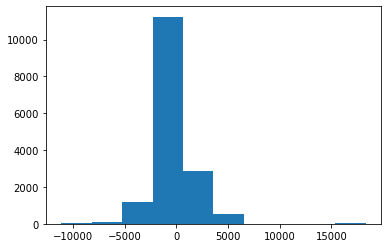

In [61]:
plt.hist(commanded_torque)[0]

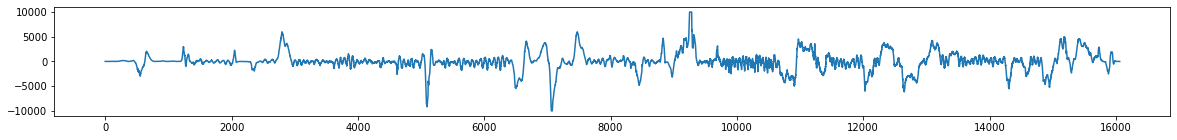

In [62]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(commanded_torque, -10_000, 10_000))

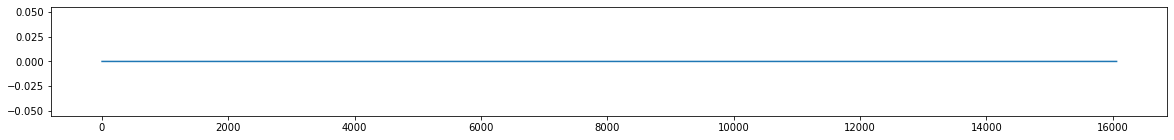

In [63]:
# abs torque limited
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 9])

array([ 254.,   94.,  129.,  760., 6525., 6816.,  683.,  191.,  130.,
        479.])

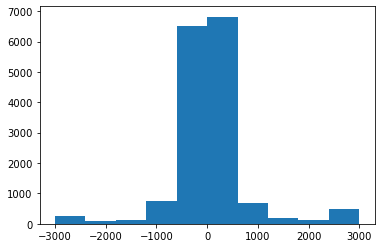

In [64]:
commanded_td = car_state[:, 8]
plt.hist(np.clip(commanded_td, -3000, 3000))[0]

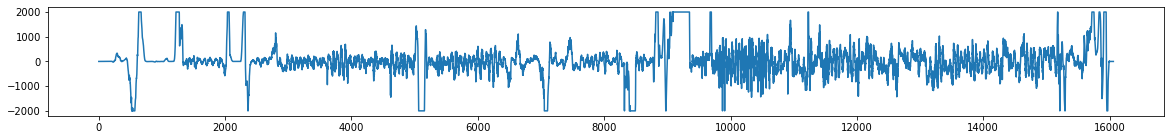

In [65]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(commanded_td, -2000, 2000))

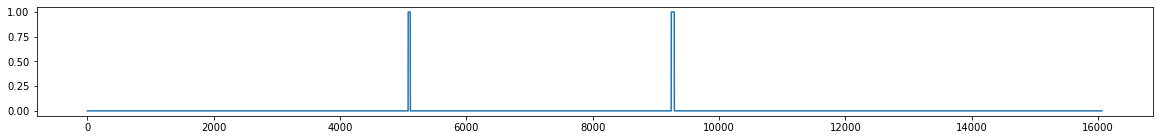

In [66]:
# Td limited
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 10])

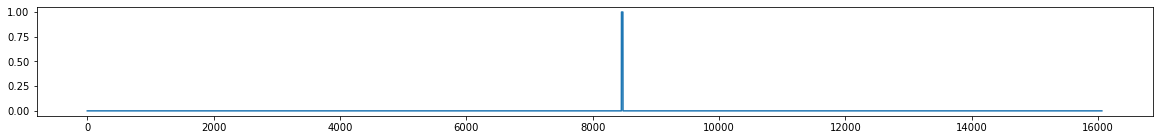

In [67]:
# interesting note
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 11])

In [68]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(car_state[:, 10], width=900, height=400)
fig.show()

In [69]:
#plt.imshow(img[15_750])

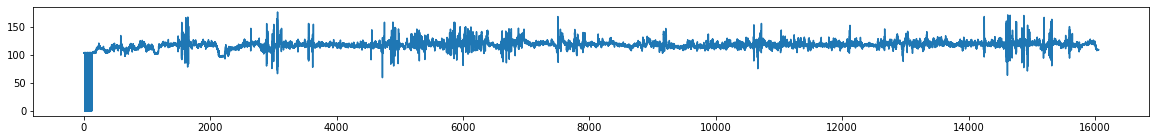

In [70]:
# seeing if cam is too slow, ie if we ever have repeated imgs

diffs = []
for i in range(len(img)-1):
    diff = (img[i] - img[i+1]).mean()
    diffs.append(diff)
    
# whether or not image is same as prev img, ie cam is slow. We just don't want to see zeros
plt.figure(figsize=(20,2))
plt.plot(diffs)

(array([1.592e+04, 1.240e+02, 5.000e+00, 1.100e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 14. ,  20.1,  26.2,  32.3,  38.4,  44.5,  50.6,  56.7,  62.8,
         68.9,  75. ,  81.1,  87.2,  93.3,  99.4, 105.5, 111.6, 117.7,
        123.8, 129.9, 136. ], dtype=float16),
 <BarContainer object of 20 artists>)

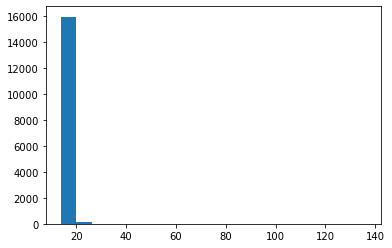

In [71]:
# timespan btwn start to get img, and publish plan, ie the timespan WE have control over
# img staleness
plt.hist(car_state[:,2], bins=20)

In [72]:
b,e = 0, -1
img = img[b:e]
aux = aux[b:e]
car_state = car_state[b:e]
steer_angle = steer_angle[b:e]
img.shape, aux.shape, car_state.shape, steer_angle.shape, #pred.shape

((16060, 100, 640, 3), (16060, 5), (16060, 12), (16060,))

(array([  62.,  323.,  701.,  602., 3088., 9185.,  636.,  758.,  567.,
         138.]),
 array([-6492., -5256., -4022., -2786., -1551.,  -316.,   919.,  2154.,
         3390.,  4624.,  5860.], dtype=float16),
 <BarContainer object of 10 artists>)

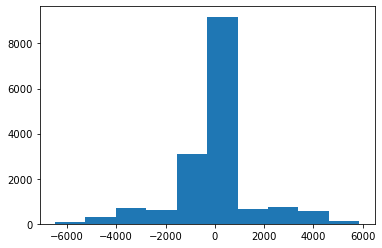

In [73]:
torque = np.degrees(steer_angle) * (aux[:,2]**2)
plt.hist(torque)

(array([4.0000e+00, 1.3000e+01, 7.7000e+01, 4.8200e+02, 4.1490e+03,
        1.0107e+04, 1.0570e+03, 1.3700e+02, 2.2000e+01, 1.1000e+01]),
 array([-475.5 , -383.5 , -291.5 , -199.6 , -107.7 ,  -15.75,   76.2 ,
         168.1 ,  260.  ,  352.  ,  444.  ], dtype=float16),
 <BarContainer object of 10 artists>)

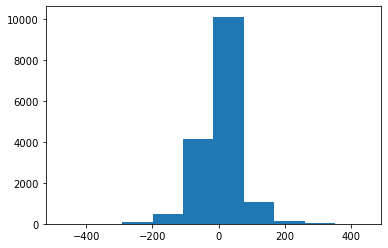

In [74]:
plt.hist(torque[1:]-torque[:-1])

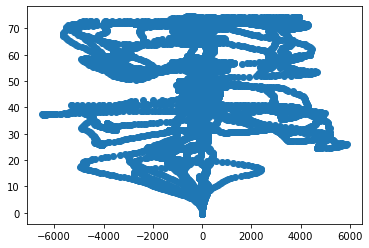

In [75]:
plt.scatter(torque, aux[:,2])

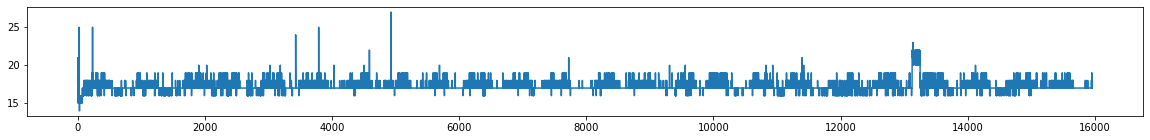

In [76]:
# img staleness
plt.figure(figsize=(20,2))
plt.plot(car_state[100:,2])

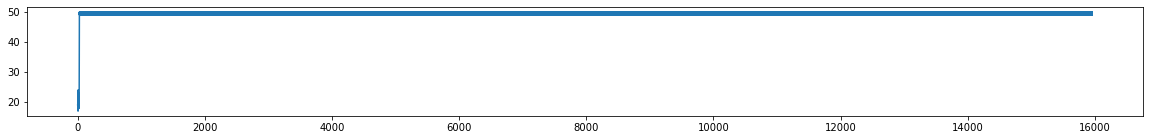

In [77]:
# loop duration
plt.figure(figsize=(20,2))
plt.plot(car_state[100:,3])

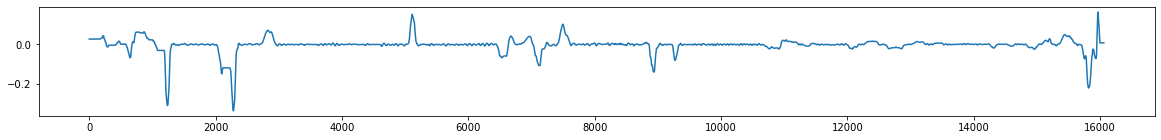

In [78]:
# steer angle
plt.figure(figsize=(20,2))
plt.plot(steer_angle)

In [79]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=range(len(steer_angle)), y=steer_angle, width=900, height=400)
fig.show()

(array([   59.,    37.,    69.,    75.,   278.,   507., 13137.,  1675.,
          154.,    69.]),
 array([-0.3376 , -0.2874 , -0.2372 , -0.187  , -0.1368 , -0.0866 ,
        -0.0364 ,  0.01381,  0.064  ,  0.1142 ,  0.1644 ], dtype=float16),
 <BarContainer object of 10 artists>)

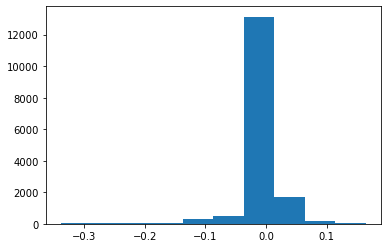

In [80]:
plt.hist(steer_angle)

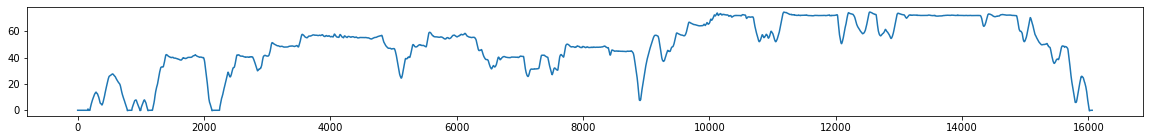

In [81]:
# speed
plt.figure(figsize=(20,2))
plt.plot(aux[:,2])

(array([ 989.,  460.,  314.,  596.,  890., 2294., 2564., 3231.,  893.,
        3829.]),
 array([-0.4453,  7.062 , 14.57  , 22.08  , 29.58  , 37.1   , 44.6   ,
        52.1   , 59.62  , 67.1   , 74.6   ], dtype=float16),
 <BarContainer object of 10 artists>)

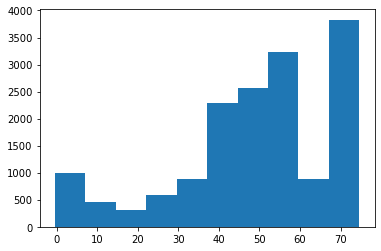

In [82]:
# speed
plt.hist(aux[:,2])

In [83]:
"""import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=kph_to_mph(aux[:, 2]), y=np.sqrt(1/abs(steer_angle+.001)), width=600, height=600)
#fig.update_xaxes(range=[0, 50])
fig.update_yaxes(range=[0, 12])
fig.show()
"""
# The speed you can go is a linear fn of sqrt(1/curvature), steer_angle is a linear fn of curvature, given wheelbase

'import plotly.express as px\nimport plotly.graph_objects as go\n\nfig = px.scatter(x=kph_to_mph(aux[:, 2]), y=np.sqrt(1/abs(steer_angle+.001)), width=600, height=600)\n#fig.update_xaxes(range=[0, 50])\nfig.update_yaxes(range=[0, 12])\nfig.show()\n'

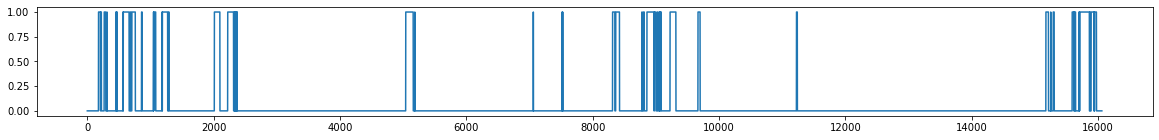

In [84]:
# steeringWheelPressed
plt.figure(figsize=(20,2))
plt.plot(car_state[:,4])

(array([   56939.,   828251.,  2634481.,  5295390.,  8268004.,  8427596.,
         9854054., 12558808.,  2849430.,   619047.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

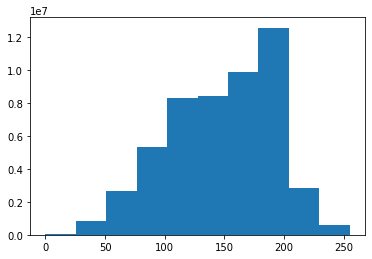

In [85]:
plt.hist(img[::20,:,:,2].flatten())

In [86]:
img.mean()

170.8657769831232

In [87]:
for i in range(len(img)):
    img[i] = gamma_correct_auto(img[i])

<BarContainer object of 10 artists>

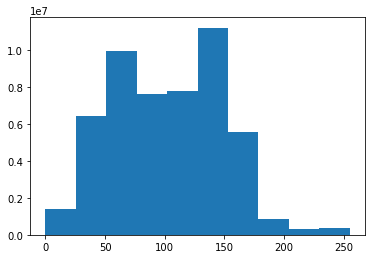

In [88]:
plt.hist(img[::20,:,:,2].flatten())[2]

In [89]:
"""for i in range(len(img)):
    img[i] = img[0] #np.concatenate([img[0].mean(axis=-1, keepdims=True) for _ in range(3)], axis=-1)    
    aux[i, 2] = 80"""

'for i in range(len(img)):\n    img[i] = img[0] #np.concatenate([img[0].mean(axis=-1, keepdims=True) for _ in range(3)], axis=-1)    \n    aux[i, 2] = 80'

In [90]:
aux[:,0] = -.5
aux[:,1] = .5

In [91]:
rollout_data = make_vid(run_id, model_stem, img, aux)

(16060, 30) (16060, 1, 13, 80) (16060, 1, 13, 80)
Made vid!


In [92]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

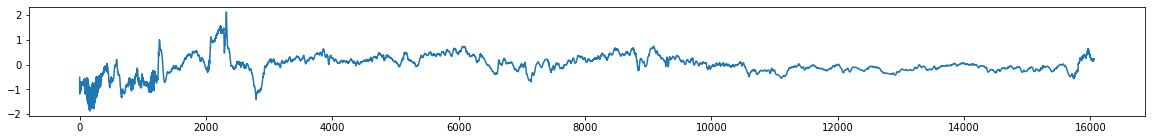

In [93]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])

In [94]:
obsnet_outs[:,1][5000:14000].mean()

0.04004

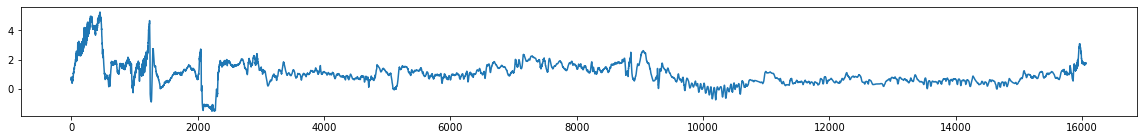

In [95]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,2])

In [96]:
obsnet_outs[:,2][5_000:14_000].mean()

0.903

In [97]:
%%time
combine_vids(model_stem, "8.3_avg", run_id)

combined!
CPU times: user 45.2 s, sys: 607 ms, total: 45.8 s
Wall time: 45.8 s
